In [ ]:
import numpy as np
import datetime
import pandas as pd
import torch
import torch.nn as nn
import time
import pickle
%run notes_events_network_join.ipynb

In [ ]:
learning_rate = 0.01
model, _ = create_model_and_optimizer()
model.load_state_dict(torch.load("../balanced_model.pt", map_location=torch.device('cpu')))

# Obtaining the mean of beta attention weight of each feature.
To do that, we are going to record the mean of the beta attention weight of each feature for batches of 1000 events

In [ ]:

batch_size = 1000
train_loader, val_loader = get_unbalanced_dataloaders()  
results = []
for step, batch in enumerate(train_loader):
    x, masks, events, events_masks, labels = batch
    print (events.shape)
    h, _ = model.events.rnn_b(events)
    beta = model.events.att_b(h)
    results.append(beta.reshape(-1,127).transpose(1,0).mean(-1).detach())


Then, we are going to calculate the mean of those means.
Each feature will end up having an attention weight.

In [ ]:
weights = torch.stack(results, dim=-1).mean(-1)
np.savetxt('weights.csv', weights.numpy())

In [8]:
features = pd.read_csv('featurescodes.csv')
weights = np.loadtxt('weights.csv')


Since each feature has a different mean, to be able to compare the weights we normalize them first by the mean of the values of each feature.

We discard those features with less than 1000 readings.

In [9]:
f = pd.concat([features, pd.DataFrame(weights)], axis=1)
f.columns = ['code', 'mimiciiitable', 'feature', 'mean', 'stddev', 'cnt', 'weight']
f['adj_weight'] = abs(f['weight']) * f['mean']
f = f[f['cnt']>1000]


In [15]:
f = f.groupby('feature').mean().sort_values(by='adj_weight', ascending=False)
f

,code,mean,stddev,cnt,weight,adj_weight
feature,,,,,,
Blood Glucose,5.000000,147.206058,69.798813,32855.000000,-0.103953,15.302549
Glucose,55.666667,219.543959,2926.100302,5838.666667,-0.003539,12.562518
Weight,116.000000,89.538627,25.962110,4863.000000,0.128866,11.538493
Systolic blood pressure,96.250000,122.187473,22.048913,4710.000000,-0.024929,7.841152
Temperature,94.000000,67.436831,3.699972,4603.166667,-0.055527,5.671658
Heart Rate,60.500000,84.878449,14.934327,7573.500000,0.040401,3.421161
Mean blood pressure,72.750000,78.746868,15.677828,4697.250000,-0.041247,3.277463
Oxygen Saturation,0.000000,89.543927,11.734493,4129.000000,-0.021507,1.925806
Diastolic blood pressure,26.200000,52.003586,24.539563,4014.200000,-0.000730,1.625209


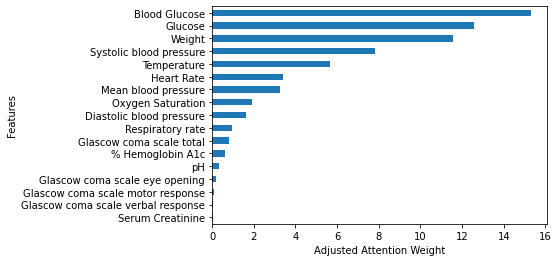

In [25]:
ax = f['adj_weight'].plot.barh()
ax.set_ylabel('Features')
ax.set_xlabel('Adjusted Attention Weight')
ax.invert_yaxis()